In [1]:
import nengo
import nengo_spa as spa
import numpy as np
from random import shuffle
import random
import sys, os
import math
from IPython import display

# Import our classes
sys.path.append('..')
import experiments as xps
from model import Model

# Select Nengo simulator according to whether we want to use ocl or not
use_ocl = True
if use_ocl:
    import nengo_ocl
    simulator_cls = nengo_ocl.Simulator
else:
    simulator_cls = nengo.Simulator
    


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from cycler import cycler
%matplotlib inline

# color-blind accessibility
default_cycler = cycler('color', ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
plt.rc('axes', prop_cycle=(default_cycler))




# Model variables

In [2]:
D = 128*3  # the dimensionality of the vectors
PROC_FDBCK = 0
GW_FDBCK = .95 # but synapse is shorter than for perfect storage
GW_SCALE = 20 # scale the input of GW for saturation and catching very short visual stimuli
BG_THR = .1
BG_BIAS = .5
STIM_DURATION = .029

# Number of neurons
N_NEURONS_SCALE = 1
N_NEURONS_PER_DIM = { # initialize to default values then scale
    module: int(number*N_NEURONS_SCALE) for module,number in { 
    'AM': 50,
    'State': 50,
    'BG': 100,
    'thal_1': 50,
    'thal_2': 40,
    'Scalar': 50 # NB: this is for the whole module (one dim)
}.items()}



keys = ['CUE.unitary()','R.unitary()','L.unitary()','ORIENT_1.unitary()','ORIENT_2.unitary()']


seed = 100

vocab = spa.Vocabulary(dimensions=D, pointer_gen=np.random.RandomState(seed), max_similarity=.02)
vocab.populate(";".join(keys))
vocab.populate('SOURCE.unitary() ; CONTENT.unitary() ;'+
                  'V.unitary() ; M.unitary()')
vocab.populate(";".join([p+"_SOURCE=(SOURCE*"+p+").normalized()" for p in ['V']])) # this is done to avoid similarity with other SPs


T = 5 - .00001# simulations run a bit too long

model = Model(vocab, STIM_DURATION, PROC_FDBCK, GW_FDBCK, GW_SCALE, BG_THR, BG_BIAS, N_NEURONS_PER_DIM, seed=seed)
model.run(T, simulator_cls)
xp = model.experiment

Seed: 100
keys dict_keys(['CUE*R', 'CUE*L', 'ORIENT_1*R', 'ORIENT_2*R', 'ORIENT_1*L', 'ORIENT_2*L'])
Number of neurons: 82380
T: 4.99999
No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

# Plot results

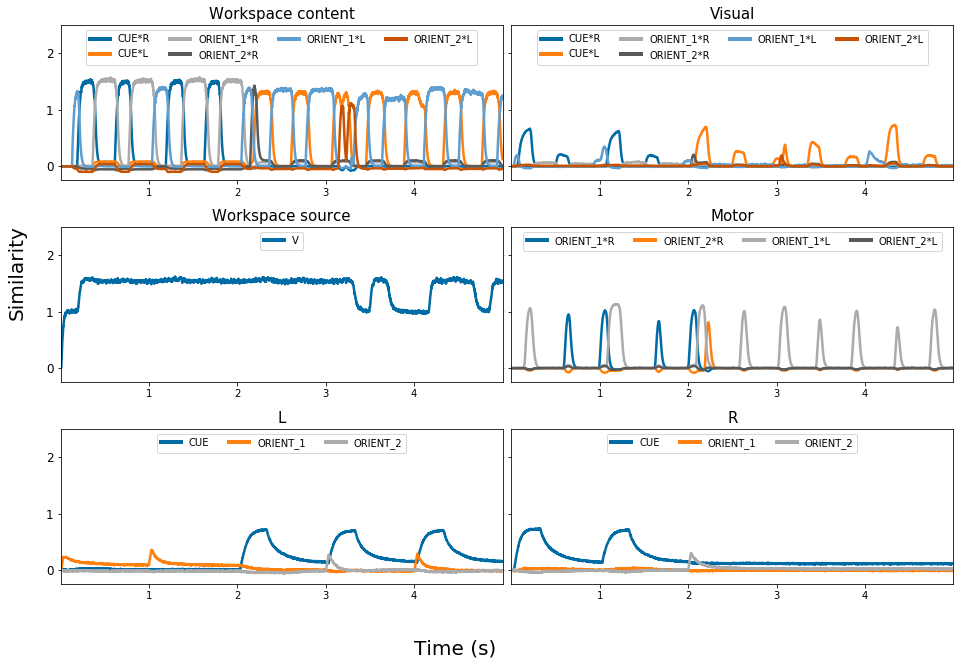

In [3]:
if True:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=False, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1):

        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        ymin, ymax = -.25, 2.5
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(False)
        plt.plot(t_range, spa.similarity(data, vectors), linewidth=2.5)
        plt.title(title, size=15)
        if subplot_i==11:
            plt.xlabel("Time (s)", size=20, labelpad=20)
#         plt.ylabel("Similarity", size=15)
        plt.xlim(left=t_range[0], right=t_range[-1])
        leg = plt.legend([k.replace('*CONTENT','') for k in keys], loc='upper center', ncol=5 if title=="Workspace source" else 4)
#         leg = plt.legend([k.replace('*CONTENT','')+': '+str(round(mean_activation[sort_idx][i],2)) for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center', ncol=3)
        
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()
            
        plt.yticks(range(3), range(3), fontsize=12 if (subplot_i-1)%2==0 else 0)
#         plt.xticks(range(1,7), range(1,7), fontsize=12 if subplot_i in [10,11,12] else 0)


        return subplot_i + 1

    

    subplot_nrows=4
    subplot_ncols=2
    plt.figure(figsize=(8*subplot_ncols,3.5*subplot_nrows))
    
    def trial_t(trial_number):
        return trial_number*1
    
    focus_start = 0 # first trial to plot
    n_focus = T # how many trials to plot
    start = trial_t(focus_start)
    end = trial_t(focus_start+n_focus)
    skip = 1
    trange = model.sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


    subplot_i=plot_similarities(trange, model.sim.data[model.probes['GW']['GW content']['out']][selected_idx][::skip], model.vocab, keys=['CUE*R','CUE*L','ORIENT_1*R','ORIENT_2*R','ORIENT_1*L','ORIENT_2*L'], title='Workspace content', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, model.sim.data[model.probes['processors']['V']['out']][selected_idx][::skip], model.vocab, keys=[stim+"*CONTENT" for stim in ['CUE*R','CUE*L','ORIENT_1*R','ORIENT_2*R','ORIENT_1*L','ORIENT_2*L']], title='Visual', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, model.sim.data[model.probes['GW']['GW source']['out']][selected_idx][::skip], model.vocab, keys=["V"], title='Workspace source', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, model.sim.data[model.probes['processors']['M']['out']][selected_idx][::skip], model.vocab, keys=[stim+"*CONTENT" for stim in ['ORIENT_1*R','ORIENT_2*R','ORIENT_1*L','ORIENT_2*L']], title='Motor', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
#     subplot_i=plot_similarities(trange, model.sim.data[model.probes['L_trans']][selected_idx][::skip], model.vocab, keys=['CUE','ORIENT_1','ORIENT_2'], title='L_trans', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
#     subplot_i=plot_similarities(trange, model.sim.data[model.probes['R_trans']][selected_idx][::skip], model.vocab, keys=['CUE','ORIENT_1','ORIENT_2'], title='R_trans', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, model.sim.data[model.probes['L']][selected_idx][::skip], model.vocab, keys=['CUE','ORIENT_1','ORIENT_2'], title='L', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, model.sim.data[model.probes['R']][selected_idx][::skip], model.vocab, keys=['CUE','ORIENT_1','ORIENT_2'], title='R', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)

#     trange = sim.trange()[selected_idx]
#     plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
#     plt.plot(trange, sim.data[p_BTN][selected_idx], color='black', linewidth=3.5)
#     plt.xlim(left=trange[0], right=trange[-1])
#     plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length))
#     plt.ylim(-.2,2.2)
#     plt.ylabel("Action")
#     plt.grid(True)

    plt.text(-1.1,-1.5,'Time (s)', fontdict={"fontsize":20})
    plt.text(-5.7,4.5,'Similarity', fontdict={"fontsize":20}, rotation=90)
    
    plt.subplots_adjust(hspace=0.3, wspace=0.02)
    
#     plt.savefig("figures/model_beha.eps")

    plt.show()
    
    
    


# Attention

In [4]:
plt.figure(figsize=(16,6))
i=0
for p in processors:
    if p.sender:
        plt.subplot(1,len(processors),i+1)
        plt.plot(trange, sim.data[p_attentions[p]][selected_idx])
        plt.title(p.label)
        plt.ylim(-.2,2.2)
        i += 1
plt.show()

NameError: name 'processors' is not defined

<Figure size 1152x432 with 0 Axes>

# Access

In [ ]:
plt.figure(figsize=(16,6))
for i in range(model.network.access_net.AS.bg.input.size_out):
    plt.subplot(1,model.network.access_net.AS.bg.input.size_out,i+1)
    plt.plot(model.sim.trange()[selected_idx], model.sim.data[model.probes['AS_nets']['access']['in']][:,i][selected_idx])
    plt.title(model.network.access_net.labels[i])
    plt.ylim(-.5,1.5)

plt.show()

plt.figure(figsize=(16,6))
for i in range(model.network.access_net.AS.bg.input.size_out):
    plt.subplot(1,model.network.access_net.AS.bg.input.size_out,i+1)
    plt.plot(model.sim.trange()[selected_idx], model.sim.data[model.probes['AS_nets']['access']['out']][:,i][selected_idx])
    plt.title(model.network.access_net.labels[i])
    plt.ylim(-.5,1.5)

plt.show()

# Routing

In [ ]:
plt.figure(figsize=(16,6))
for i in range(model.network.routing_net.AS.bg.input.size_out):
    plt.subplot(1,model.network.routing_net.AS.bg.input.size_out,i+1)
    plt.plot(model.sim.trange()[selected_idx], model.sim.data[model.probes['AS_nets']['routing']['in']][:,i][selected_idx])
    plt.title(model.network.routing_net.labels[i])
    plt.ylim(-.5,1.5)
plt.show()

plt.figure(figsize=(16,6))
for i in range(model.network.routing_net.AS.bg.input.size_out):
    plt.subplot(1,model.network.routing_net.AS.bg.input.size_out,i+1)
    plt.plot(model.sim.trange()[selected_idx], model.sim.data[model.probes['AS_nets']['routing']['out']][:,i][selected_idx])
    plt.title(model.network.routing_net.labels[i])
    plt.ylim(-.5,1.5)
plt.show()

# Receive

In [ ]:
for j,p in enumerate(model.receivers):
    
    print(p.label)

    plt.figure(figsize=(16,6))
    for i in range(model.network.broadcast_nets[j].AS.bg.input.size_out):
        plt.subplot(1,model.network.broadcast_nets[j].AS.bg.input.size_out,i+1)
        plt.plot(model.sim.trange()[selected_idx], model.sim.data[model.probes['AS_nets']['broadcast '+p.label]['in']][:,i][selected_idx])
        plt.title(model.network.broadcast_nets[j].labels[i])
    plt.show()

    plt.figure(figsize=(16,6))
    for i in range(model.network.broadcast_nets[j].AS.bg.input.size_out):
        plt.subplot(1,model.network.broadcast_nets[j].AS.bg.input.size_out,i+1)
        plt.plot(model.sim.trange()[selected_idx], model.sim.data[model.probes['AS_nets']['broadcast '+p.label]['out']][:,i][selected_idx])
        plt.title(model.network.broadcast_nets[j].labels[i])
    plt.show()